# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml
import math
from lfads_k09 import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')
import shutil
path = './models_k09'
if os.path.isdir(path): 
    shutil.rmtree(path)

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cpu


## Load or Generate Data 

In [3]:
"""all_time =28000
start_time = 25000
Time = 500
neuron_num = 83
datax = scipy.io.loadmat("spike83_k09_35000.mat")
y_data = datax["spike83_k09_35000"][:,start_time:all_time].T
traj = scipy.io.loadmat("trj83_k09_35000.mat")
traj = traj["trj83_k09_35000"][:,start_time:all_time].T"""
all_time =17000
start_time = 15000
Time = 300
neuron_num = 76
datax = scipy.io.loadmat("spike76_k09_17000.mat")
y_data = datax["spike76_k09_17000"][:,start_time:all_time].T
traj = scipy.io.loadmat("trj76_k09_17000.mat")
traj = traj["trj76_k09_17000"][:,start_time:all_time].T
NRep=int((all_time-start_time)/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(all_time-start_time):
    for j in range(neuron_num):
        if y_data[i][j] > 25:
            y_data[i][j] = 25
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

(2000, 76)
torch.Size([6, 300, 76])


## View example Ground Truth Firing Rates

(300, 76)


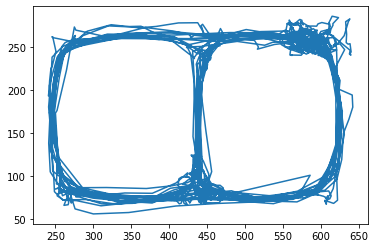

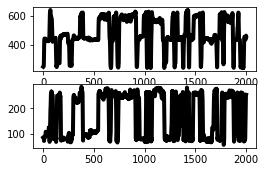

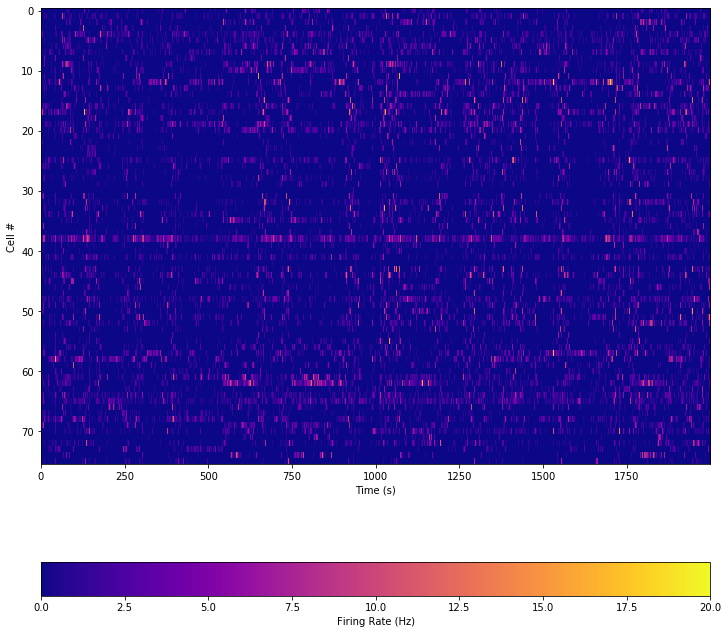

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

In [5]:
"""for i in range(neuron_num):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=10,s=3)
    fig.colorbar(mappable)
    plt.title(i)
    plt.show()"""
#fig.savefig("img.png")

"for i in range(neuron_num):\n    fig, ax = plt.subplots()\n    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=10,s=3)\n    fig.colorbar(mappable)\n    plt.title(i)\n    plt.show()"

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_k09.yaml')
save_parameters(hyperparams)
hyperparams

C:\Users\flab\prog\lfads_torch_k09\utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 80,
 'u_dim': 30,
 'factors_dim': 2,
 'g0_encoder_dim': 80,
 'c_encoder_dim': 30,
 'controller_dim': 30,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.012,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.9,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 7990


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 20
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [ ]:
model.fit(train_ds, valid_ds, max_epochs=400, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

Beginning training...
Epoch:    1, Step:     1, training loss: 35831.090
recon: 35830, kl:     0, dir:    0, smo:    0, klf:    0, klw: 0.000500
Epoch:    2, Step:     2, training loss: 31375.457
recon: 31374, kl:     0, dir:    0, smo:    0, klf:    0, klw: 0.001000
Epoch:    3, Step:     3, training loss: 30019.379
recon: 30018, kl:     0, dir:    0, smo:    0, klf:    0, klw: 0.001500
Epoch:    4, Step:     4, training loss: 28985.273
recon: 28984, kl:     0, dir:    0, smo:    0, klf:    0, klw: 0.002000
Epoch:    5, Step:     5, training loss: 28322.688
recon: 28321, kl:     1, dir:    0, smo:    0, klf:    0, klw: 0.002500
Epoch:    6, Step:     6, training loss: 27943.428
recon: 27941, kl:     1, dir:    0, smo:    0, klf:    0, klw: 0.003000
Epoch:    7, Step:     7, training loss: 27370.457
recon: 27368, kl:     1, dir:    0, smo:    0, klf:    0, klw: 0.003500
Epoch:    8, Step:     8, training loss: 27016.420
recon: 27013, kl:     1, dir:    0, smo:    0, klf:    0, klw: 0.0

Epoch:   68, Step:    68, training loss: 22443.197
recon: 22437, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.034000
Epoch:   69, Step:    69, training loss: 22411.863
recon: 22406, kl:     4, dir:    0, smo:    0, klf:    1, klw: 0.034500
Epoch:   70, Step:    70, training loss: 22332.168
recon: 22327, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.035000
Epoch:   71, Step:    71, training loss: 22321.564
recon: 22316, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.035500
Epoch:   72, Step:    72, training loss: 22303.678
recon: 22298, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.036000
Epoch:   73, Step:    73, training loss: 22252.088
recon: 22247, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.036500
Epoch:   74, Step:    74, training loss: 22150.199
recon: 22145, kl:     3, dir:    0, smo:    0, klf:    0, klw: 0.037000
Epoch:   75, Step:    75, training loss: 22123.092
recon: 22118, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.037500
Epoch:   76, Ste

Epoch:  135, Step:   135, training loss: 20192.619
recon: 20187, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.067500
Epoch:  136, Step:   136, training loss: 20164.084
recon: 20158, kl:     5, dir:    0, smo:    0, klf:    0, klw: 0.068000
Epoch:  137, Step:   137, training loss: 20131.576
recon: 20125, kl:     5, dir:    0, smo:    0, klf:    0, klw: 0.068500
Epoch:  138, Step:   138, training loss: 20164.254
recon: 20158, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.069000
Epoch:  139, Step:   139, training loss: 20078.811
recon: 20073, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.069500
Epoch:  140, Step:   140, training loss: 20130.523
recon: 20124, kl:     4, dir:    0, smo:    0, klf:    0, klw: 0.070000
Epoch:  141, Step:   141, training loss: 20033.666
recon: 20027, kl:     5, dir:    0, smo:    0, klf:    0, klw: 0.070500
Epoch:  142, Step:   142, training loss: 20087.400
recon: 20081, kl:     5, dir:    0, smo:    0, klf:    0, klw: 0.071000
Epoch:  143, Ste

## Load checkpoint with lowest validation error 

In [ ]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros(((all_time-start_time),2))
sp = np.zeros(((all_time-start_time),neuron_num))
batch_size=1
gg = int(NRep/batch_size)
import math
def mutual_info(m):
    K=30
    h_y_xw = np.zeros(neuron_num)
    h_y_x = np.zeros(neuron_num)
    T = m.shape[0]
    for n in range(neuron_num):
        for k in range(K):
            h_y_xw_tem = 0
            h_y_x_tem = 0
            for t in range(T):
                h_y_xw_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)) * np.log(m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)))
                h_y_x_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k))
            h_y_xw[n] += h_y_xw_tem/T
            h_y_x[n] -= h_y_x_tem/T * math.log(h_y_x_tem/T)
            
    return  h_y_xw.sum(), h_y_x.sum()

for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    spi = model.reconstruct(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(spi.shape)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:] = t[i][j].to('cpu').detach().numpy().copy()
            #print(model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10))
            #y_hat = model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10)
            #print(mutual_info(y_hat))
            #obs_mc_mean = y_hat.mean(axis=0)
            #obs_mc_std = y_hat.std(axis=0)
            #print(poisson_entropy(np.round(obs_mc_mean)))
            for l in range(neuron_num):
                sp[(i+batch_size*k)*Time+j,l] = spi[j][l]
plt.figure()
plt.plot(tt)

In [ ]:
#next_state = model.transition_rnn(tt[:1,:])
#print(next_state)

## Plot results summary 

In [ ]:
"""for i in range(neuron_num):
    plt.figure()
    plt.plot(y_data[:,i], linewidth = 2)
    plt.plot(sp[:,i],'r',linewidth = 1)
    plt.title(i)
    plt.ylim(-2,20)"""

In [ ]:
import funs
from scipy import signal
qz_mean_est = tt
#plt.plot(qz_mean_est[:,1])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
qz_est_norm[:,0] = signal.savgol_filter(qz_est_norm[:,0], 11, 5)
qz_est_norm[:,1] = signal.savgol_filter(qz_est_norm[:,1],11, 5)
plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 21, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],21, 5)
st=0
en=1000
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[st:en,0],'r', linewidth = 1, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[st:en,0], 'k', linewidth = 1, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[st:en,1],'r', linewidth = 1, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[st:en,1], 'k', linewidth = 1, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[st:en,0], z_true_norm[st:en,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[st:en,0], qz_est_norm_R[st:en,1], lw=2, color = 'r')

In [ ]:
#np.savetxt('lfads_k09_01170748.csv', qz_est_norm, delimiter=',')

In [ ]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(2000):
    x_list = []
    y_list = []
    x_list2 = []
    y_list2 = []
    for j in range(i):
        x = qz_est_norm_R[j,0]
        y = qz_est_norm_R[j,1]
        x2 = z_true_norm[j,0]
        y2 = z_true_norm[j,1]
        x_list.append(x)
        y_list.append(y)
        x_list2.append(x2)
        y_list2.append(y2)

    im = plt.plot(x_list,y_list,color='b',ls='solid', 
         marker='*',ms=18,markevery=slice(i-1,i,1))
    im2 = plt.plot(x_list2,y_list2,color='r',ls='solid', 
         marker='*',ms=18,markevery=slice(i-1,i,1))
    ims.append(im+im2)

ani = animation.ArtistAnimation(fig,ims,interval=50)
plt.show()